In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# load data
df = pd.read_csv('cleaned_metadata.csv')

print("\nFirst few rows:")
df.head()


First few rows:


,uid,data_provider,region,lat,lon,date,time,abun,severity,distance_to_water_m,month,season,is_near_water,abundance_class
0,aabm,Indiana_State_Department_of_Health,midwest,39.080319,-86.430867,2018-05-14,15:00:00,0.585,1,0.0,5,Spring,True,Low
1,aabn,California_Environmental_Data_Exchange_Network,west,36.559700,-121.510000,2016-08-31,16:15:00,5867.500,4,3512.0,8,Summer,False,High
2,aacd,NC_Division_of_Water_Resources_NC_Department_o...,south,35.875083,-78.878434,2020-11-19,0:01:00,0.290,1,514.0,11,Autumn,False,Low
3,aaee,NC_Division_of_Water_Resources_NC_Department_o...,south,35.487000,-79.062133,2016-08-24,0:01:00,1.614,1,129.0,8,Summer,False,Low
4,aaff,Bureau_of_Water_Kansas_Department_of_Health_an...,midwest,38.049471,-99.827001,2019-07-23,0:01:00,111.825,3,19.0,7,Summer,True,Moderate



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23569 entries, 0 to 23568
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   uid                  23569 non-null  object 
 1   data_provider        23569 non-null  object 
 2   region               23569 non-null  object 
 3   lat                  23569 non-null  float64
 4   lon                  23569 non-null  float64
 5   date                 23569 non-null  object 
 6   time                 23569 non-null  object 
 7   abun                 23569 non-null  float64
 8   severity             23569 non-null  int64  
 9   distance_to_water_m  23569 non-null  float64
 10  month                23569 non-null  int64  
 11  season               23569 non-null  object 
 12  is_near_water        23569 non-null  bool   
 13  abundance_class      23392 non-null  object 
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 2.4+ MB

Severit

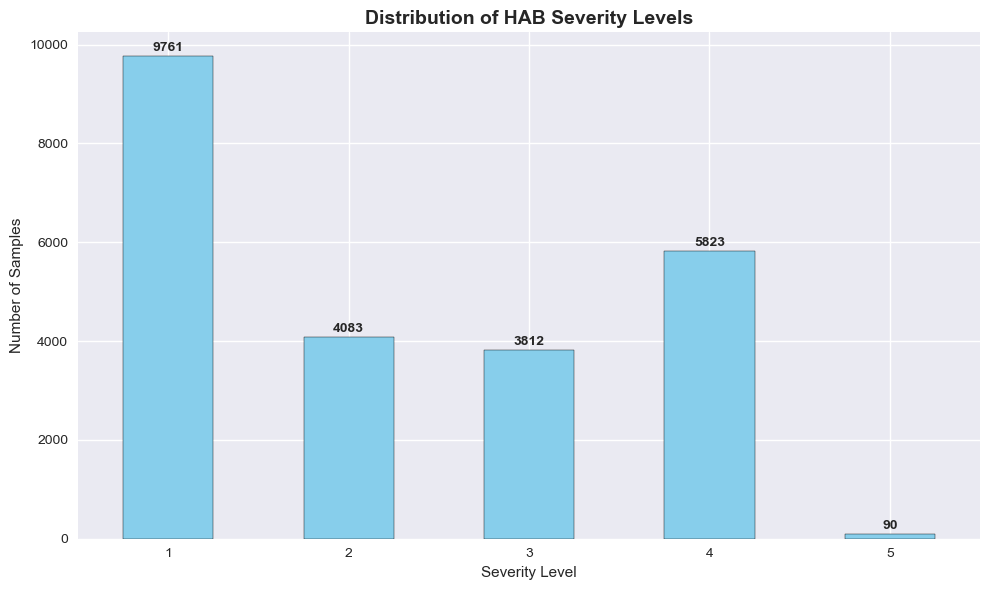

In [3]:
print("\nData Info:")
df.info()

print("\nSeverity Distribution:")
severity_counts = df['severity'].value_counts().sort_index()
print(severity_counts)

# Visualize severity distribution
plt.figure(figsize=(10, 6))
severity_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of HAB Severity Levels', fontsize=14, fontweight='bold')
plt.xlabel('Severity Level')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
for i, v in enumerate(severity_counts.values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:
# load a prep cleaned HAB data
def load_and_preprocess_data(df):
    data = df.copy()
    
    # changing date to datetime
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['day_of_year'] = data['date'].dt.dayofyear
    data['week_of_year'] = data['date'].dt.isocalendar().week
    data['hour'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.hour
    
    # encode categorical variables
    le_region = LabelEncoder()
    le_provider = LabelEncoder()
    le_season = LabelEncoder()
    le_abundance_class = LabelEncoder()
    
    data['region_encoded'] = le_region.fit_transform(data['region'])
    data['provider_encoded'] = le_provider.fit_transform(data['data_provider'])
    data['season_encoded'] = le_season.fit_transform(data['season'])
    data['abundance_class_encoded'] = le_abundance_class.fit_transform(data['abundance_class'])
    
    # boolean string to numeric
    data['is_near_water_numeric'] = (data['is_near_water'] == 'True').astype(int)
    
    
    # Select features for modeling
    feature_columns = ['lat', 'lon', 'year', 'month', 'day_of_year', 'week_of_year', 'hour', 'distance_to_water_m', 'region_encoded', 'provider_encoded',
                      'season_encoded', 'is_near_water_numeric']
    
    X = data[feature_columns]
    y = data['severity']
    
    # Print feature info
    print(f"Features used: {feature_columns}")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().sort_index().to_dict()}")
    
    return X, y, data

X, y, processed_df = load_and_preprocess_data(df)

Features used: ['lat', 'lon', 'year', 'month', 'day_of_year', 'week_of_year', 'hour', 'distance_to_water_m', 'region_encoded', 'provider_encoded', 'season_encoded', 'is_near_water_numeric']
Feature matrix shape: (23569, 12)
Target distribution: {1: 9761, 2: 4083, 3: 3812, 4: 5823, 5: 90}


In [5]:
# compare the different tree based classifiers
def evaluate_models(X, y):    
    # standard 80 - 20 train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    
    # scale features for distance-based algorithms
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # models to compare
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1,
            class_weight='balanced'
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, 
            random_state=42
        ),
        'Extra Trees': ExtraTreesClassifier(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1,
            class_weight='balanced'
        ),
        'SVM (RBF)': SVC(
            kernel='rbf', 
            random_state=42,
            class_weight='balanced'
        ),
        'Logistic Regression': LogisticRegression(
            random_state=42, 
            max_iter=1000,
            class_weight='balanced'
        ),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced'
        )
    }
    
    results = {}
    
    print("=" * 10)
    print("MODELRESULTS")
    print("=" * 10)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # use scaled data for distance based algorithms
        if name in ['SVM (RBF)', 'Logistic Regression', 'K-Nearest Neighbors']:
            X_train_use = X_train_scaled
            X_test_use = X_test_scaled
        else:
            X_train_use = X_train
            X_test_use = X_test
        
        model.fit(X_train_use, y_train)
        
        y_pred = model.predict(X_test_use)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='accuracy')
        
        results[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'model': model
        }
        
        print(f"{name}:")
        print(f"  Test Accuracy: {accuracy:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return results, X_test, y_test, scaler

results, X_test, y_test, scaler = evaluate_models(X, y)

Training set size: 18855
Test set size: 4714
MODELRESULTS

Training Random Forest...
Random Forest:
  Test Accuracy: 0.6714
  F1 Score: 0.6700
  CV Accuracy: 0.6801 (+/- 0.0064)

Training Gradient Boosting...
Gradient Boosting:
  Test Accuracy: 0.6920
  F1 Score: 0.6469
  CV Accuracy: 0.6942 (+/- 0.0086)

Training Extra Trees...
Extra Trees:
  Test Accuracy: 0.6661
  F1 Score: 0.6657
  CV Accuracy: 0.6707 (+/- 0.0090)

Training SVM (RBF)...
SVM (RBF):
  Test Accuracy: 0.5738
  F1 Score: 0.6030
  CV Accuracy: 0.5637 (+/- 0.0291)

Training Logistic Regression...
Logistic Regression:
  Test Accuracy: 0.5490
  F1 Score: 0.5785
  CV Accuracy: 0.5407 (+/- 0.0206)

Training K-Nearest Neighbors...
K-Nearest Neighbors:
  Test Accuracy: 0.6689
  F1 Score: 0.6520
  CV Accuracy: 0.6622 (+/- 0.0119)

Training Decision Tree...
Decision Tree:
  Test Accuracy: 0.6443
  F1 Score: 0.6472
  CV Accuracy: 0.6395 (+/- 0.0102)



SUMMARY TABLE:
                     Test Accuracy  F1 Score  CV Mean  CV Std
Random Forest               0.6714    0.6700   0.6801  0.0032
Gradient Boosting           0.6920    0.6469   0.6942  0.0043
Extra Trees                 0.6661    0.6657   0.6707  0.0045
SVM (RBF)                   0.5738    0.6030   0.5637  0.0145
Logistic Regression         0.5490    0.5785   0.5407  0.0103
K-Nearest Neighbors         0.6689    0.6520   0.6622  0.0060
Decision Tree               0.6443    0.6472   0.6395  0.0051


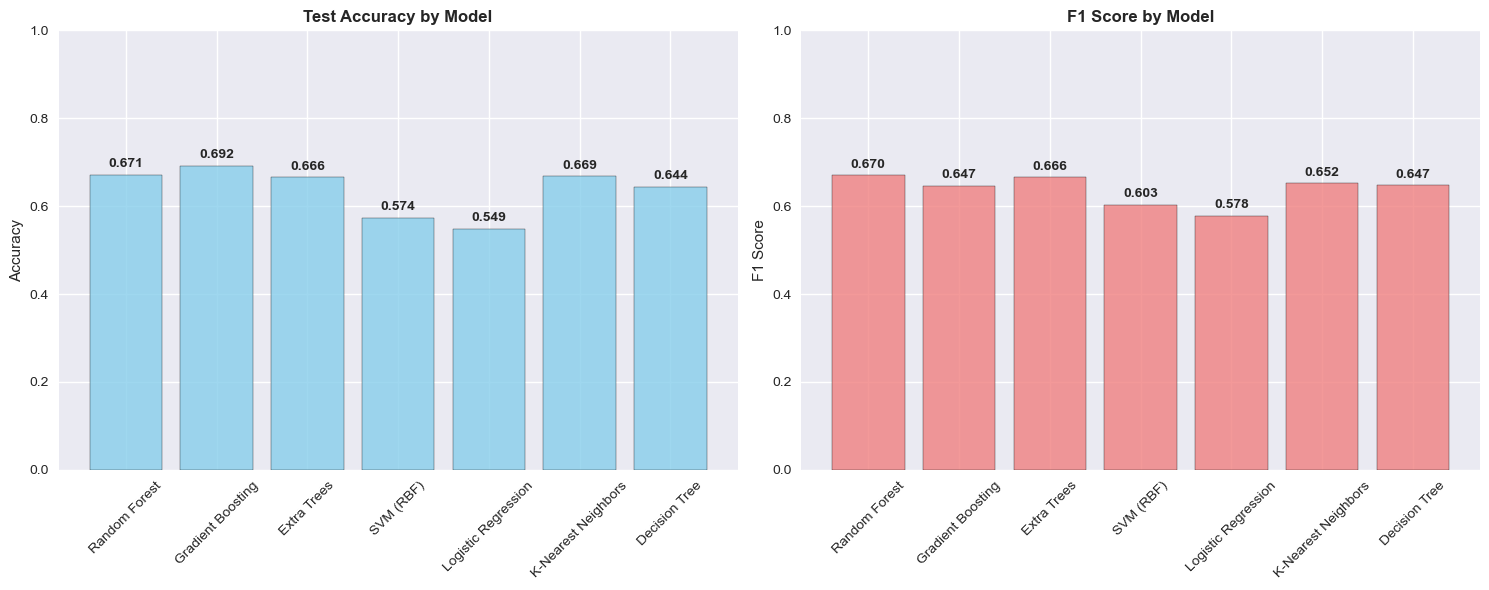

In [6]:
# Create results summary
results_df = pd.DataFrame({
    name: {
        'Test Accuracy': results[name]['accuracy'],
        'F1 Score': results[name]['f1_score'],
        'CV Mean': results[name]['cv_mean'],
        'CV Std': results[name]['cv_std']
    }
    for name in results.keys()
}).T

print("\nSUMMARY TABLE:")
print(results_df.round(4))

# Plot model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
f1_scores = [results[name]['f1_score'] for name in model_names]

# Bar plot for accuracy
bars1 = axes[0].bar(model_names, accuracies, alpha=0.8, color='skyblue', edgecolor='black')
axes[0].set_title('Test Accuracy by Model', fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Bar plot for F1 score
bars2 = axes[1].bar(model_names, f1_scores, alpha=0.8, color='lightcoral', edgecolor='black')
axes[1].set_title('F1 Score by Model', fontweight='bold')
axes[1].set_ylabel('F1 Score')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, f1 in zip(bars2, f1_scores):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
# best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\n Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"F1 Score: {results[best_model_name]['f1_score']:.4f}")

print(f"\nClassification Report for {best_model_name}:")
print("=" * 50)
print(classification_report(y_test, best_predictions))



 Best Model: Gradient Boosting
Test Accuracy: 0.6920
F1 Score: 0.6469

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           1       0.65      0.93      0.76      1952
           2       0.44      0.10      0.16       817
           3       0.51      0.40      0.45       762
           4       0.94      0.91      0.93      1165
           5       0.31      0.22      0.26        18

    accuracy                           0.69      4714
   macro avg       0.57      0.51      0.51      4714
weighted avg       0.66      0.69      0.65      4714



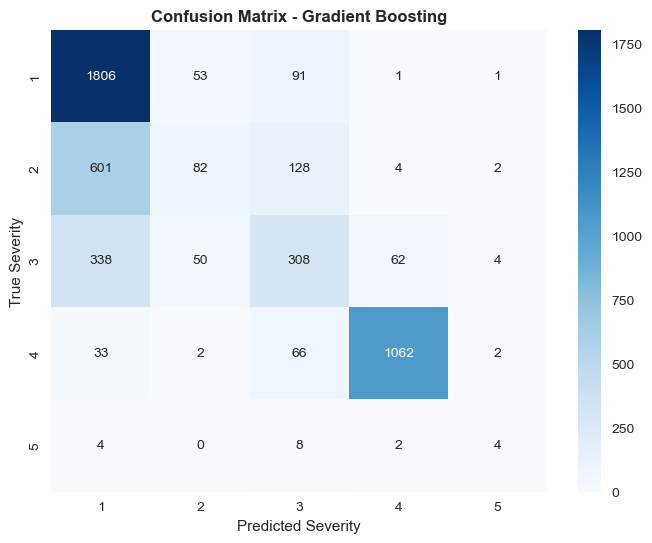


Per-class accuracy for Gradient Boosting:
Severity 1: 0.925
Severity 2: 0.100
Severity 3: 0.404
Severity 4: 0.912
Severity 5: 0.222


In [8]:
# confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.xlabel('Predicted Severity')
plt.ylabel('True Severity')
plt.show()

#  per-class accuracy
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(f"\nPer-class accuracy for {best_model_name}:")
for i in range(5):
    print(f"Severity {i+1}: {cm_normalized[i, i]:.3f}")


Top 10 Most Important Features (Gradient Boosting):
                feature  importance
1                   lon    0.671441
9      provider_encoded    0.164192
0                   lat    0.077447
4           day_of_year    0.032792
7   distance_to_water_m    0.019104
2                  year    0.014422
5          week_of_year    0.013356
6                  hour    0.004631
10       season_encoded    0.001821
3                 month    0.000531


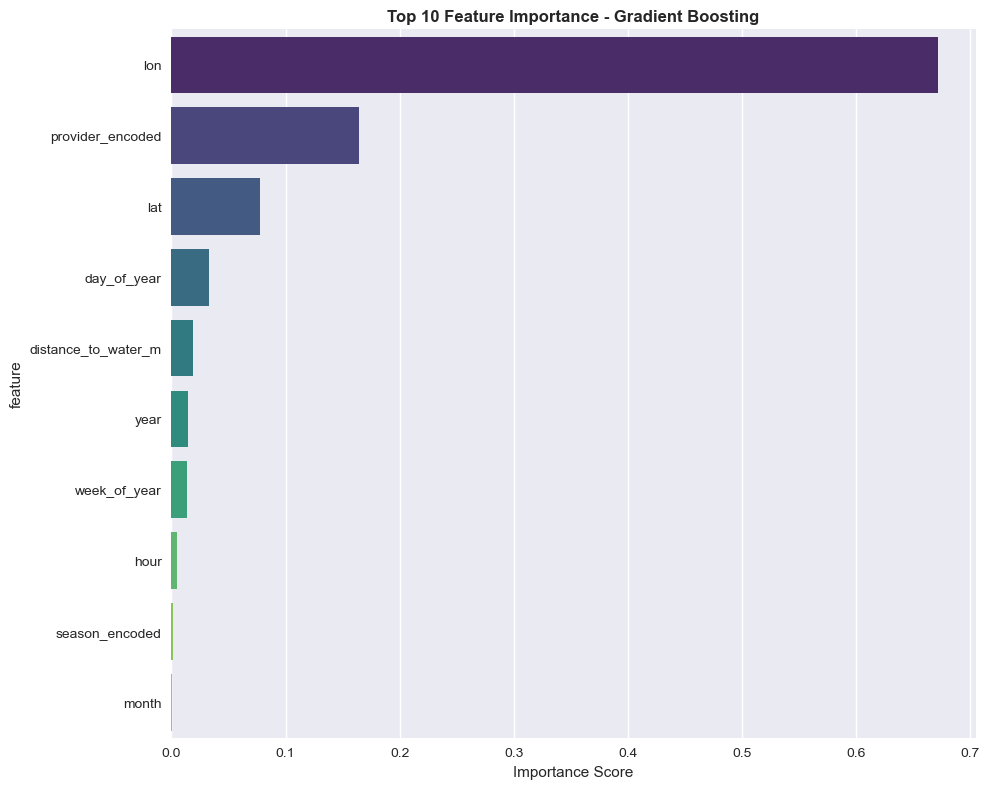

In [9]:
if best_model_name in ['Random Forest', 'Gradient Boosting', 'Extra Trees', 'Decision Tree']:
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features ({best_model_name}):")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(10)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 10 Feature Importance - {best_model_name}', fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

In [10]:
# models performance by severity level
performance_by_class = pd.DataFrame(index=range(1, 6))
performance_by_class.index.name = 'Severity'

for severity in range(1, 6):
    mask = (y_test == severity)
    if mask.sum() > 0:
        class_predictions = best_predictions[mask]
        class_true = y_test[mask]
        accuracy = accuracy_score(class_true, class_predictions)
        
        performance_by_class.loc[severity, 'Count'] = mask.sum()
        performance_by_class.loc[severity, 'Accuracy'] = accuracy
    else:
        performance_by_class.loc[severity, 'Count'] = 0
        performance_by_class.loc[severity, 'Accuracy'] = 0

print("\nPerformance by Severity Level:")
print(performance_by_class)


Performance by Severity Level:
           Count  Accuracy
Severity                  
1         1952.0  0.925205
2          817.0  0.100367
3          762.0  0.404199
4         1165.0  0.911588
5           18.0  0.222222
